In [1]:
import glob
import os
import numpy as np
from typing import Dict, List
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.trials import align_trials, select_trials
import pandas as pd
from scipy import stats
from joblib import Parallel, delayed
from tqdm import tqdm
from ephysvibe.stats import smetrics
seed = 1997

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [58]:
def get_selectivity_info(neu: NeuronData):
    win=100
    res = {}
    res["nid"] = neu.get_neuron_id()
    samples = [11, 15, 51, 55, 0]
    for inout in ["in", "out"]:
        mask = getattr(neu, "mask_" + inout)
        sp = getattr(neu, "sample_on_" + inout)
        st = getattr(neu, "st_sample_on_" + inout)
        fr = firing_rate.moving_average(data=sp, win=100, step=1)[:, :-win] #
        sample_id = neu.sample_id[mask]
        fr_samples = select_trials.get_sp_by_sample(fr, sample_id, samples)
        o1 = np.concatenate((fr_samples["11"], fr_samples["15"]))
        o5 = np.concatenate((fr_samples["51"], fr_samples["55"]))
        c1 = np.concatenate((fr_samples["11"], fr_samples["51"]))
        c5 = np.concatenate((fr_samples["15"], fr_samples["55"]))
        sample = np.concatenate(
            (fr_samples["11"], fr_samples["15"], fr_samples["51"], fr_samples["55"])
        )
        n0 = fr_samples["0"]
        # Check selectivity and latency
        color_lat, color_score,color_p = smetrics.get_selectivity(c1, c5, win=75, scores=True)
        color_selec = (
            np.nan
            if np.isnan(color_lat)
            else "c1" if color_score[color_lat] > 0 else "c5"
        )
        orient_lat, orient_score, orient_p = smetrics.get_selectivity(o1, o5, win=75, scores=True)
        orient_selec = (
            np.nan
            if np.isnan(orient_lat)
            else "o1" if orient_score[orient_lat] > 0 else "o5"
        )
        neutral_lat, neutral_score, neutral_p = smetrics.get_selectivity(
            sample, n0, win=75, scores=True
        )
        neutral_selec = (
            np.nan
            if np.isnan(neutral_lat)
            else "NN" if neutral_score[neutral_lat] > 0 else "N"
        )

        res["color_lat_" + inout] = color_lat
        res["color_selec_" + inout] = color_selec
        res["color_score_" + inout] = color_score
        res["color_p_" + inout] = color_p
        res["orient_lat_" + inout] = orient_lat
        res["orient_selec_" + inout] = orient_selec
        res["orient_score_" + inout] = orient_score
        res["orient_p_" + inout] = orient_p
        res["neutral_lat_" + inout] = neutral_lat
        res["neutral_selec_" + inout] = neutral_selec
        res["neutral_score_" + inout] = neutral_score
        res["neutral_p_" + inout] = neutral_p
        res["mean_fr_" + inout] = np.nanmean(sp[:,st:] * 1000)

    return res

In [70]:
def get_neu_align (path,params,sp_sample=False):

    neu = NeuronData.from_python_hdf5(path)
    for it in params:
        sp, mask = neu.align_on(
                select_block=it["select_block"],
                select_pos=it["inout"],
                event=it["event"],
                time_before=it["time_before"],
                error_type=0,
            )
        endt=it['time_before']+it['end']
        stt=it['time_before']+it['st']
        setattr(neu, it['sp'], np.array(sp[:,:endt],dtype=it["dtype_sp"]))
        setattr(neu, it['mask'], np.array(mask,dtype=it["dtype_mask"]))
        setattr(neu, 'st_'+it["event"]+'_'+it["inout"], np.array(stt,dtype=int))
        setattr(neu, 'time_before_'+it["event"]+'_'+it["inout"], np.array(it['time_before'],dtype=int))

    if ~sp_sample: setattr(neu, 'sp_samples', np.array([]))

    return neu

In [60]:
# Define parameters
areas = ["lip"]
subject = "Riesling"
# paths
filepaths = {
    "lip": "D:/data/session_struct/lip/neurons/",
    "pfc": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/pfc/neurons/",
    "v4": "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/new_structure/session_struct/v4/neurons/",
}

for area in areas:
    print(area)
    path = filepaths[area]
    neu_path = path + "*neu.h5"
    path_list = glob.glob(neu_path)

lip


In [99]:
200+450*3+300

1850

In [62]:
params =[{'inout':'in','sp':'sample_on_in','mask':'mask_in','event':'sample_on','time_before':300,'st':0,'end':1550,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool},
         {'inout':'out','sp':'sample_on_out','mask':'mask_out','event':'sample_on','time_before':300,'st':0,'end':1550,'select_block':1,'win':100,'dtype_sp':np.int8,'dtype_mask':bool}]

In [63]:
str(params)

"[{'inout': 'in', 'sp': 'sample_on_in', 'mask': 'mask_in', 'event': 'sample_on', 'time_before': 300, 'st': 0, 'end': 1550, 'select_block': 1, 'win': 100, 'dtype_sp': <class 'numpy.int8'>, 'dtype_mask': <class 'bool'>}, {'inout': 'out', 'sp': 'sample_on_out', 'mask': 'mask_out', 'event': 'sample_on', 'time_before': 300, 'st': 0, 'end': 1550, 'select_block': 1, 'win': 100, 'dtype_sp': <class 'numpy.int8'>, 'dtype_mask': <class 'bool'>}]"

In [72]:
population = Parallel(n_jobs=-1)(
    delayed(get_neu_align)(neu,params) for neu in tqdm(path_list[221:223])
)

100%|██████████| 2/2 [00:00<00:00, 221.42it/s]


In [74]:
comment= str(params)
population = PopulationData(population, comment=comment)
population.to_python_hdf5('res/test.h5')

In [76]:
popu=PopulationData.from_python_hdf5('res/test.h5')

In [77]:
popu.population[0].__dict__.keys()

dict_keys(['date_time', 'subject', 'area', 'experiment', 'recording', 'sp_samples', 'cluster_id', 'cluster_ch', 'cluster_group', 'cluster_number', 'cluster_array_pos', 'cluster_depth', 'block', 'trial_error', 'code_samples', 'code_numbers', 'position', 'pos_code', 'sample_id', 'test_stimuli', 'test_distractor', 'mask_in', 'mask_out', 'sample_on_in', 'sample_on_out', 'st_sample_on_in', 'st_sample_on_out', 'time_before_sample_on_in', 'time_before_sample_on_out'])

In [78]:
df_selectivity = popu.execute_function(get_selectivity_info, n_jobs=-1, ret_df=False)

100%|██████████| 2/2 [00:00<00:00, 500.19it/s]


In [79]:
df_selectivity=pd.DataFrame(df_selectivity)
df_selectivity.head()

In [131]:
df_selectivity.to_pickle('test.csv')

### Load DF

In [196]:
area='lip'
df_fr=pd.read_csv("res/population_fr_" + area + ".csv")#.drop('Unnamed: 0', axis=1) 
df_selectivity=pd.read_pickle("res/population_selectivity_" + area + ".pkl")
df_merge=pd.merge(df_selectivity, df_fr, left_on='nid',right_on='nid')

In [197]:
df_sel1=df_merge[np.logical_or(df_merge['fr_sampleNNin']>=1,df_merge['fr_sampleNNout']>=1)]

df_sel_in=df_sel1[df_sel1['spmax_bl_ratio_sampleNNin']>1]
df_sel_out=df_sel1[df_sel1['spmax_bl_ratio_sampleNNout']>1]

Text(0.5, 1.0, 'orient_lat_out')

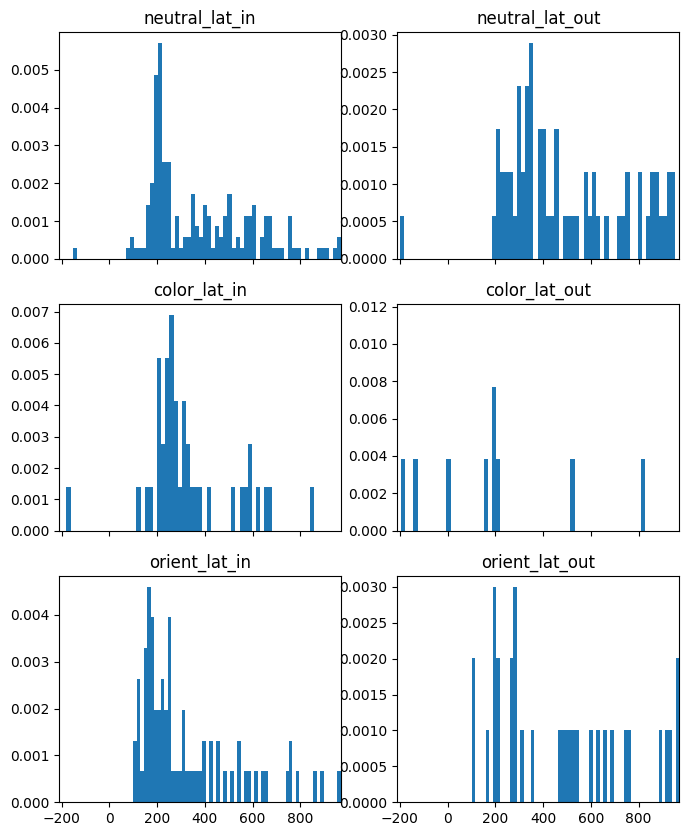

In [198]:
f,ax=plt.subplots(3,2,figsize=(8,10),sharex=True)
ax[0,0].hist(df_sel_in[df_sel_in['neutral_lat_in'].notna()]['neutral_lat_in']-200,density=True,bins=100) 
ax[0,0].set_title('neutral_lat_in')
ax[0,1].hist(df_sel_out[df_sel_out['neutral_lat_out'].notna()]['neutral_lat_out']-200,density=True,bins=100) 
ax[0,1].set_title('neutral_lat_out')
ax[0,0].set_xlim(-210,970)
ax[0,1].set_xlim(-210,970)

ax[1,0].hist(df_sel_in[df_sel_in['color_lat_in'].notna()]['color_lat_in']-200,density=True,bins=100) 
ax[1,0].set_title('color_lat_in')
ax[1,1].hist(df_sel_out[df_sel_out['color_lat_out'].notna()]['color_lat_out']-200,density=True,bins=100) 
ax[1,1].set_title('color_lat_out')

ax[2,0].hist(df_sel_in[df_sel_in['orient_lat_in'].notna()]['orient_lat_in']-200,density=True,bins=100) 
ax[2,0].set_title('orient_lat_in')
ax[2,1].hist(df_sel_out[df_sel_out['orient_lat_out'].notna()]['orient_lat_out']-200,density=True,bins=100) 
ax[2,1].set_title('orient_lat_out')

In [199]:
df_sel_in_contra = df_sel_in[df_sel_in['fr_sampleNNin']>df_sel_in['fr_sampleNNout']]
df_sel_in_ipsi = df_sel_in[df_sel_in['fr_sampleNNin']<df_sel_in['fr_sampleNNout']]
df_sel_out_contra = df_sel_out[df_sel_out['fr_sampleNNin']>df_sel_out['fr_sampleNNout']]
df_sel_out_ipsi = df_sel_out[df_sel_out['fr_sampleNNin']<df_sel_out['fr_sampleNNout']]

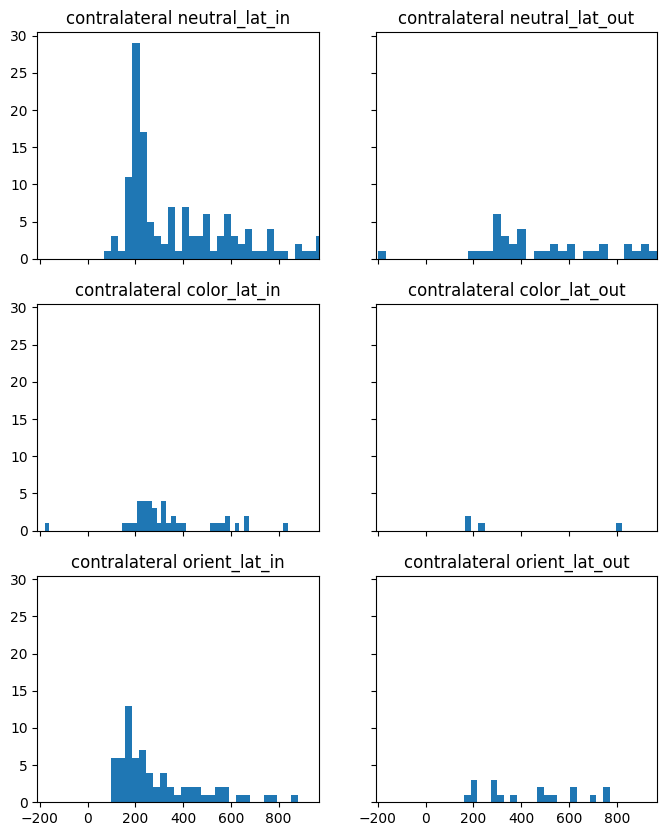

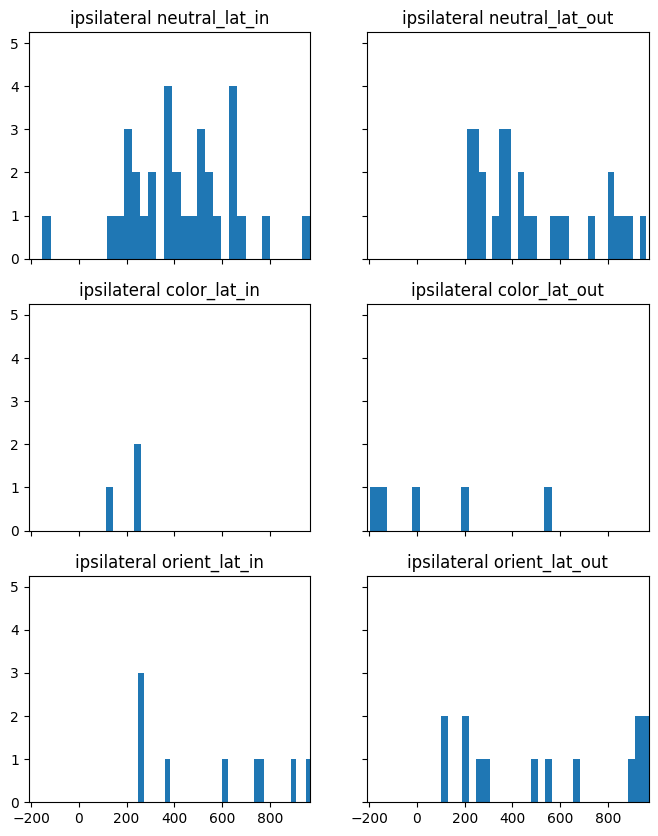

In [200]:
for indf,outdf,ipsicontra in zip([df_sel_in_contra,df_sel_in_ipsi],[df_sel_out_contra,df_sel_out_ipsi],['contralateral','ipsilateral']):
    f,ax=plt.subplots(3,2,figsize=(8,10),sharex=True,sharey=True)
    ax[0,0].hist(indf[indf['neutral_lat_in'].notna()]['neutral_lat_in']-200,density=False,bins=50) 
    ax[0,0].set_title(ipsicontra+' neutral_lat_in')
    ax[0,1].hist(outdf[outdf['neutral_lat_out'].notna()]['neutral_lat_out']-200,density=False,bins=50) 
    ax[0,1].set_title(ipsicontra+' neutral_lat_out')
    ax[0,0].set_xlim(-210,970)
    ax[0,1].set_xlim(-210,970)

    ax[1,0].hist(indf[indf['color_lat_in'].notna()]['color_lat_in']-200,density=False,bins=50) 
    ax[1,0].set_title(ipsicontra+' color_lat_in')
    ax[1,1].hist(outdf[outdf['color_lat_out'].notna()]['color_lat_out']-200,density=False,bins=50) 
    ax[1,1].set_title(ipsicontra+' color_lat_out')

    ax[2,0].hist(indf[indf['orient_lat_in'].notna()]['orient_lat_in']-200,density=False,bins=50) 
    ax[2,0].set_title(ipsicontra+' orient_lat_in')
    ax[2,1].hist(outdf[outdf['orient_lat_out'].notna()]['orient_lat_out']-200,density=False,bins=50) 
    ax[2,1].set_title(ipsicontra+' orient_lat_out')

In [201]:
df_sel1.columns

Index(['nid', 'color_lat_in', 'color_selec_in', 'color_score_in', 'color_p_in',
       'orient_lat_in', 'orient_selec_in', 'orient_score_in', 'orient_p_in',
       'neutral_lat_in',
       ...
       'spfix_bl_ratio_delay1Nout', 'spmax_bl_ratio_delay1Nout',
       'p_maxfr_delay1Nout', 'fr_delay2Nout', 'maxfrlat_delay2Nout',
       'maxfr_delay2Nout', 'maxfr200_delay2Nout', 'spfix_bl_ratio_delay2Nout',
       'spmax_bl_ratio_delay2Nout', 'p_maxfr_delay2Nout'],
      dtype='object', length=111)

In [214]:
def get_sorted_scores(score,latencies):
    shifts=np.where(np.isnan(latencies),0,latencies).astype(int)

    mean_score = np.mean(align_trials.indep_roll(arr=score, shifts=-shifts, axis = 1)[:,:200],axis=1)

    positive_mask = mean_score>=0
    negative_mask = mean_score<0

    positive_sorted_idx = np.argsort(latencies[positive_mask])
    negative_sorted_idx = np.argsort(latencies[negative_mask])

    sorted_neg_scores = score[negative_mask][negative_sorted_idx]
    sorted_pos_scores = score[positive_mask][positive_sorted_idx][::-1]
    sorted_scores = np.concatenate((sorted_neg_scores,sorted_pos_scores),axis=0)

    sorted_neg_latencies = latencies[negative_mask][negative_sorted_idx]
    sorted_pos_latencies = latencies[positive_mask][positive_sorted_idx][::-1]
    sorted_latencies = np.concatenate((sorted_neg_latencies,sorted_pos_latencies),axis=0)

    return sorted_scores, sorted_latencies

In [215]:
def plot_latencies(df,lat_key,score_key,ax,max_len=1850):
    
    lat = df[score_key].values.tolist()
    #lists = [lst if isinstance(lst, np.ndarray) else np.array([]) for lst in lat]
    padded_lists = [np.pad(lst, (0, max_len - len(lst)), constant_values=np.nan) for lst in lat]
    score=np.array(padded_lists)
    latencies = df[lat_key].values
    sorted_scores, sorted_latencies = get_sorted_scores(score,latencies)
    sns.heatmap(sorted_scores, vmin=-1, vmax=1, cmap='PiYG',ax=ax)
    ax.scatter(sorted_latencies,np.arange(len(sorted_latencies))+0.5,s=0.2,color='k')
    x_ticks = np.arange(0,sorted_scores.shape[1],50)
    ax.set_xticks(x_ticks)
    _=ax.set_xticklabels(x_ticks- 300 )
    ax.vlines([300,450+300,1200+300],ax.get_ylim()[0],ax.get_ylim()[1],'k','--')
    ax.set_title(lat_key)
    return latencies

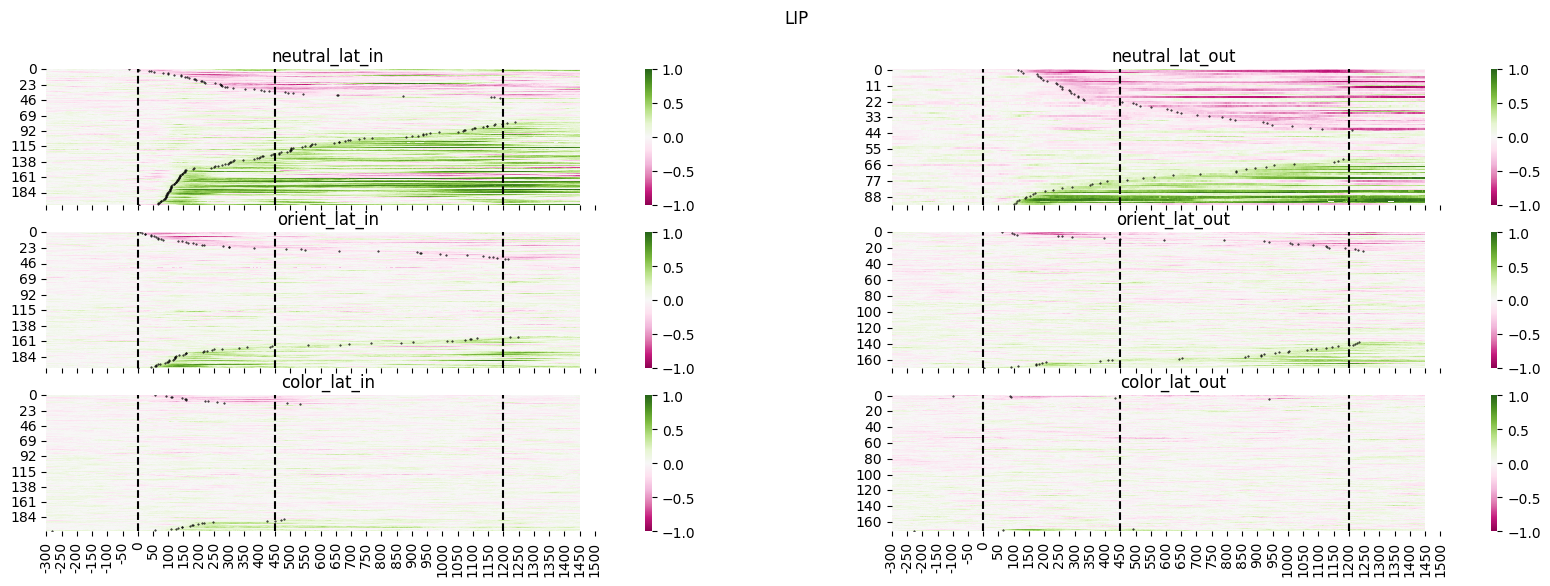

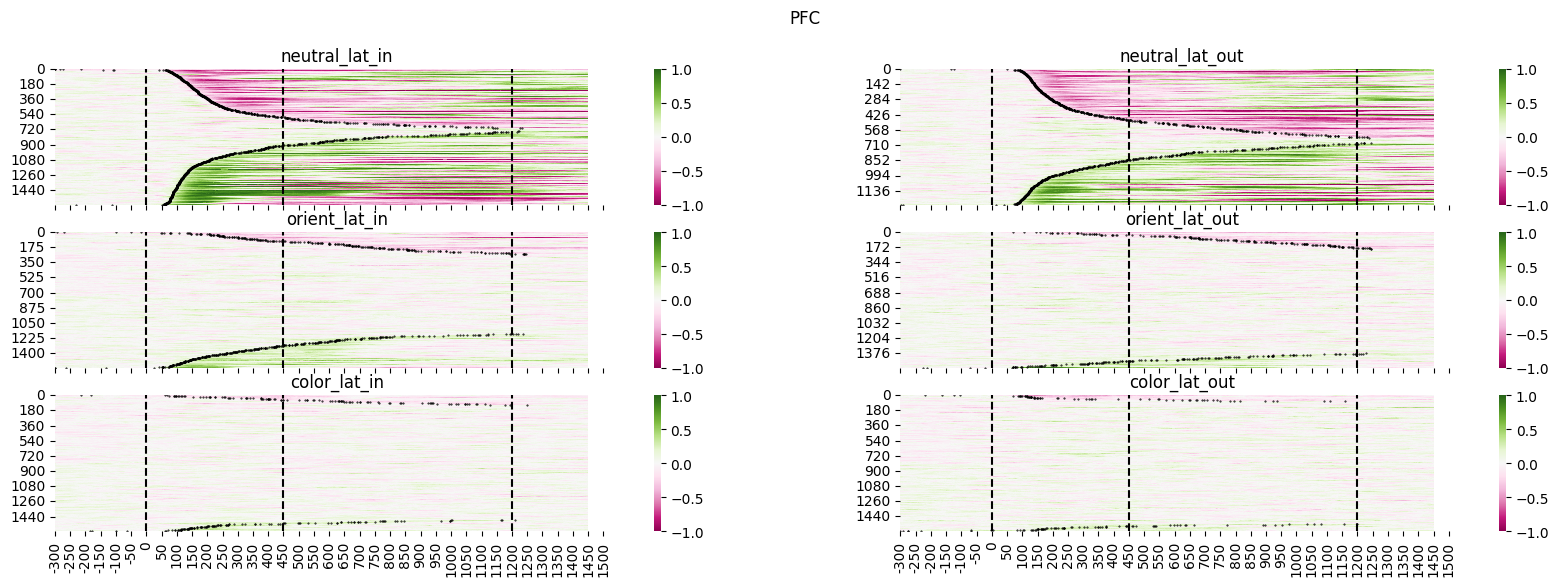

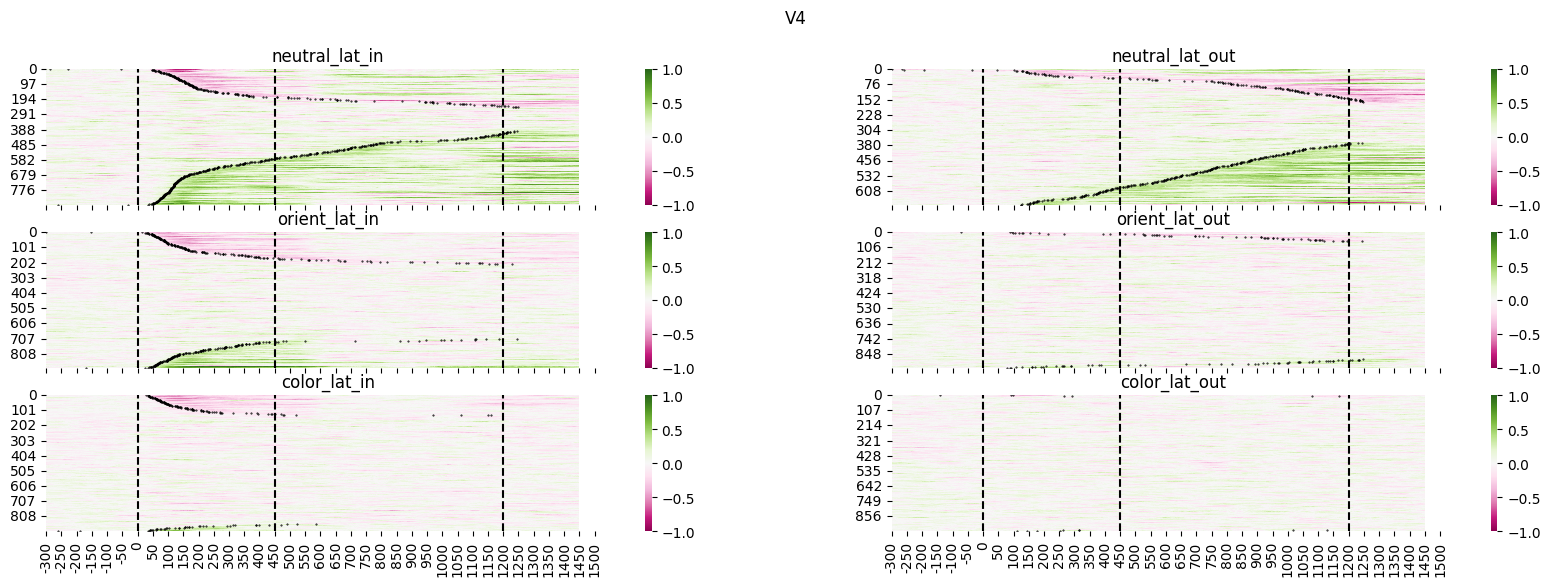

In [228]:
all_lat = {'lip':{},'pfc':{},'v4':{}}
for area in ['lip','pfc','v4']:
    df_sel=pd.read_pickle("res/population_selectivity_" + area + ".pkl")
    df_sel_in =  df_sel[df_sel['mean_fr_in']>5]
    df_sel_out = df_sel[df_sel['mean_fr_out']>5]
    f,ax=plt.subplots(3,2,figsize=(20,6),sharex=True)
    latencies = plot_latencies(df_sel_in,lat_key='neutral_lat_in',score_key='neutral_score_in',ax=ax[0,0])
    all_lat[area]["neutral_lat_in"] = latencies-300
    # ------------------------------------------------------
    latencies = plot_latencies(df_sel_in,lat_key='orient_lat_in',score_key='orient_score_in',ax=ax[1,0])
    all_lat[area]["orient_lat_in"] = latencies-300
    # ------------------------------------------------------
    latencies = plot_latencies(df_sel_in,lat_key='color_lat_in',score_key='color_score_in',ax=ax[2,0])
    all_lat[area]["color_lat_in"] = latencies-300
    # out -------------------------------------------------
    latencies = plot_latencies(df_sel_out,lat_key='neutral_lat_out',score_key='neutral_score_out',ax=ax[0,1])
    all_lat[area]["neutral_lat_out"] = latencies-300
    # ------------------------------------------------------
    latencies = plot_latencies(df_sel_out,lat_key='orient_lat_out',score_key='orient_score_out',ax=ax[1,1])
    all_lat[area]["orient_lat_out"] = latencies-300
    # ------------------------------------------------------
    latencies = plot_latencies(df_sel_out,lat_key='color_lat_out',score_key='color_score_out',ax=ax[2,1])
    all_lat[area]["color_lat_out"] = latencies-300
    f.suptitle(area.upper())

In [273]:
info_bar=[]
for key in ['in','out']:
    info_bar_plot = {'lip':{},'pfc':{},'v4':{}}
    for area in ['lip','pfc','v4']:
        lat =all_lat[area]['orient_lat_'+key]
        lat=lat[np.logical_and(lat>0, lat< 1200)]
        info_bar_plot[area]['orient'] = [np.nanmedian(lat),stats.median_abs_deviation(lat,nan_policy='omit')]
        lat =all_lat[area]['color_lat_'+key]
        lat=lat[np.logical_and(lat>0, lat< 1200)]
        info_bar_plot[area]['color'] = [np.nanmedian(lat),stats.median_abs_deviation(lat,nan_policy='omit')]
        
        lat =all_lat[area]['neutral_lat_'+key]
        lat=lat[np.logical_and(lat>0, lat< 1200)]
        info_bar_plot[area]['neutral'] = [np.nanmedian(lat),stats.median_abs_deviation(lat,nan_policy='omit')]
    info_bar.append(info_bar_plot)

Text(0.5, 0.98, 'Latencies from 0 to 1200 ms')

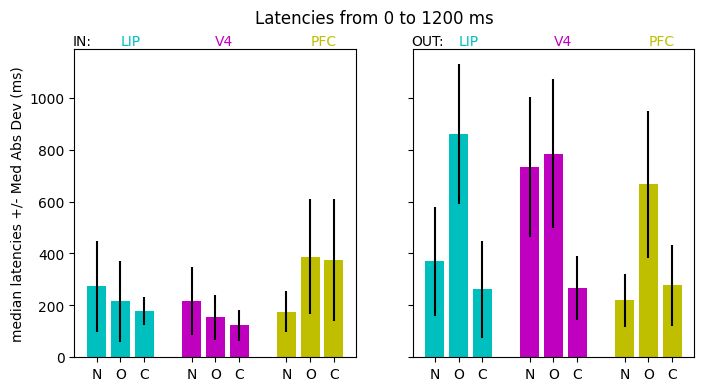

In [274]:
f,ax=plt.subplots(1,2,figsize=(8,4),sharey=True)
tikcs = np.arange(1,10)
alltikcs=tikcs+np.concatenate(([0]*3,[1]*3,[2]*3))
info_bar_in = info_bar[0]
medianlat = [[info_bar_in[area]['neutral'][0],info_bar_in[area]['orient'][0],info_bar_in[area]['color'][0]] for area in ['lip','v4','pfc'] ] 
madlat = [[info_bar_in[area]['neutral'][1],info_bar_in[area]['orient'][1],info_bar_in[area]['color'][1]] for area in ['lip','v4','pfc'] ] 
labels = [['N','O','C'] for area in ['lip','pfc','v4'] ] 
ax[0].bar(alltikcs,np.concatenate(medianlat), yerr=np.concatenate(madlat),width=0.8, color=np.concatenate((['c']*3,['m']*3, ['y']*3)))
ax[0].set_xticks(alltikcs, labels=np.concatenate(labels))
ax[0].text(0, 1200, 'IN:', color='k')
ax[0].text(2, 1200, 'LIP', color='c')
ax[0].text(6, 1200, 'V4', color='m')
ax[0].text(10, 1200, 'PFC', color='y')
ax[0].set_ylabel('median latencies +/- Med Abs Dev (ms)')
# OUT
tikcs = np.arange(1,10)
alltikcs=tikcs+np.concatenate(([0]*3,[1]*3,[2]*3))
info_bar_in = info_bar[1]
medianlat = [[info_bar_in[area]['neutral'][0],info_bar_in[area]['orient'][0],info_bar_in[area]['color'][0]] for area in ['lip','v4','pfc'] ] 
madlat = [[info_bar_in[area]['neutral'][1],info_bar_in[area]['orient'][1],info_bar_in[area]['color'][1]] for area in ['lip','v4','pfc'] ] 
labels = [['N','O','C'] for area in ['lip','pfc','v4'] ] 
ax[1].bar(alltikcs,np.concatenate(medianlat), yerr=np.concatenate(madlat),width=0.8, color=np.concatenate((['c']*3,['m']*3, ['y']*3)))
ax[1].set_xticks(alltikcs, labels=np.concatenate(labels))
ax[1].text(0, 1200, 'OUT:', color='k')
ax[1].text(2, 1200, 'LIP', color='c')
ax[1].text(6, 1200, 'V4', color='m')
ax[1].text(10, 1200, 'PFC', color='y')
f.suptitle('Latencies from 0 to 1200 ms')

In [277]:
info_bar_sample=[]
for key in ['in','out']:
    info_bar_plot = {'lip':{},'pfc':{},'v4':{}}
    for area in ['lip','pfc','v4']:
        lat =all_lat[area]['orient_lat_'+key]
        lat=lat[np.logical_and(lat>0, lat< 450)]
        info_bar_plot[area]['orient'] = [np.nanmedian(lat),stats.median_abs_deviation(lat,nan_policy='omit')]
        lat =all_lat[area]['color_lat_'+key]
        lat=lat[np.logical_and(lat>0, lat< 450)]
        info_bar_plot[area]['color'] = [np.nanmedian(lat),stats.median_abs_deviation(lat,nan_policy='omit')]
        
        lat =all_lat[area]['neutral_lat_'+key]
        lat=lat[np.logical_and(lat>0, lat< 450)]
        info_bar_plot[area]['neutral'] = [np.nanmedian(lat),stats.median_abs_deviation(lat,nan_policy='omit')]
    info_bar_sample.append(info_bar_plot)

Text(0.5, 0.98, 'latencies from 0 to 450 ms')

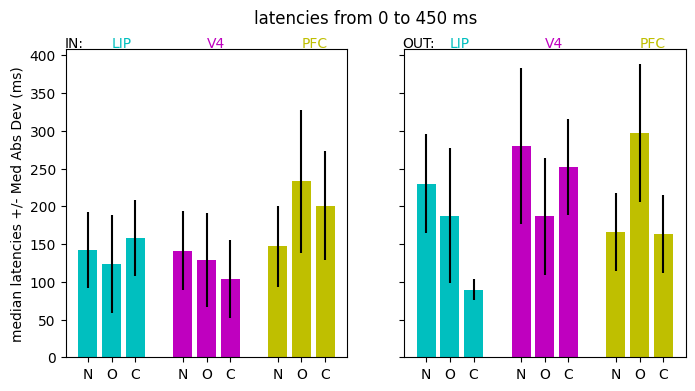

In [278]:
f,ax=plt.subplots(1,2,figsize=(8,4),sharey=True)
tikcs = np.arange(1,10)
alltikcs=tikcs+np.concatenate(([0]*3,[1]*3,[2]*3))
info_bar_in = info_bar_sample[0]
medianlat = [[info_bar_in[area]['neutral'][0],info_bar_in[area]['orient'][0],info_bar_in[area]['color'][0]] for area in ['lip','v4','pfc'] ] 
madlat = [[info_bar_in[area]['neutral'][1],info_bar_in[area]['orient'][1],info_bar_in[area]['color'][1]] for area in ['lip','v4','pfc'] ] 
labels = [['N','O','C'] for area in ['lip','pfc','v4'] ] 
ax[0].bar(alltikcs,np.concatenate(medianlat), yerr=np.concatenate(madlat),width=0.8, color=np.concatenate((['c']*3,['m']*3, ['y']*3)))
ax[0].set_xticks(alltikcs, labels=np.concatenate(labels))
ax[0].text(0, 410, 'IN:', color='k')
ax[0].text(2, 410, 'LIP', color='c')
ax[0].text(6, 410, 'V4', color='m')
ax[0].text(10, 410, 'PFC', color='y')
ax[0].set_ylabel('median latencies +/- Med Abs Dev (ms)')
# OUT
tikcs = np.arange(1,10)
alltikcs=tikcs+np.concatenate(([0]*3,[1]*3,[2]*3))
info_bar_in = info_bar_sample[1]
medianlat = [[info_bar_in[area]['neutral'][0],info_bar_in[area]['orient'][0],info_bar_in[area]['color'][0]] for area in ['lip','v4','pfc'] ] 
madlat = [[info_bar_in[area]['neutral'][1],info_bar_in[area]['orient'][1],info_bar_in[area]['color'][1]] for area in ['lip','v4','pfc'] ] 
labels = [['N','O','C'] for area in ['lip','pfc','v4'] ] 
ax[1].bar(alltikcs,np.concatenate(medianlat), yerr=np.concatenate(madlat),width=0.8, color=np.concatenate((['c']*3,['m']*3, ['y']*3)))
ax[1].set_xticks(alltikcs, labels=np.concatenate(labels))
ax[1].text(0, 410, 'OUT:', color='k')
ax[1].text(2, 410, 'LIP', color='c')
ax[1].text(6, 410, 'V4', color='m')
ax[1].text(10, 410, 'PFC', color='y')
f.suptitle('latencies from 0 to 450 ms')